<a href="https://colab.research.google.com/github/pkmariya/Scaler01/blob/master/ZeeRecommender_CaseStudy_Mariya_DSML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The Objective is to create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### Data Loading

In [3]:
# Import required libraries
# Libraries for Data Processing
import numpy as np
import pandas as pd
import scipy.stats
import re
import io

# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Similarity check
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import files
uploaded = files.upload()

Saving zee-ratings.dat to zee-ratings.dat
Saving zee-movies.dat to zee-movies.dat
Saving zee-users.dat to zee-users.dat


In [6]:
for fn in uploaded.keys():
  print('The file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

The file "zee-ratings.dat" with length 24594166 bytes
The file "zee-movies.dat" with length 171332 bytes
The file "zee-users.dat" with length 134410 bytes


In [7]:
users = pd.read_csv('zee-users.dat', sep='::', usecols=['UserID', "Gender", 'Age', 'Occupation', 'Zip-code'])
users.to_csv ('zee-users.csv', index=None)

In [8]:
movies = pd.read_csv('zee-movies.dat', sep='::', encoding='windows-1252', usecols=['Movie ID', 'Title', 'Genres'])
movies.to_csv('zee-movies.csv', index=None)
# movies_df = pd.read_csv(io.StringIO(uploaded['zee-movies.dat'].decode('utf-8')))

In [9]:
ratings = pd.read_csv('zee-ratings.dat', sep='::', usecols=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings.to_csv ('zee-ratings.csv', index=None)

In [10]:
user_df = pd.read_csv('zee-users.csv')
movies_df = pd.read_csv('zee-movies.csv')
ratings_df = pd.read_csv('zee-ratings.csv')

### Pre-Processing

In [9]:
user_df.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040.000000,6040,6040.000000,6040.000000,6040
unique,NaN,2,NaN,NaN,3439
top,NaN,M,NaN,NaN,48104
freq,NaN,4331,NaN,NaN,19
mean,3020.500000,NaN,30.639238,8.146854,NaN
std,1743.742145,NaN,12.895962,6.329511,NaN
min,1.000000,NaN,1.000000,0.000000,NaN
25%,1510.750000,NaN,25.000000,3.000000,NaN
50%,3020.500000,NaN,25.000000,7.000000,NaN
75%,4530.250000,NaN,35.000000,14.000000,NaN


In [10]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [11]:
user_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [12]:
user_df.nunique()

UserID        6040
Gender           2
Age              7
Occupation      21
Zip-code      3439
dtype: int64

In [13]:
movies_df.describe(include='all')

,Movie ID,Title,Genres
count,3883.000000,3883,3883
unique,NaN,3883,301
top,NaN,Toy Story (1995),Drama
freq,NaN,1,843
mean,1986.049446,NaN,NaN
std,1146.778349,NaN,NaN
min,1.000000,NaN,NaN
25%,982.500000,NaN,NaN
50%,2010.000000,NaN,NaN
75%,2980.500000,NaN,NaN


In [72]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [15]:
movies_df.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
movies_df.nunique()

Movie ID    3883
Title       3883
Genres       301
dtype: int64

In [17]:
ratings_df.describe(include='all')

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [170]:
# Number of users
print('The ratings dataset has', ratings_df['UserID'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings_df['MovieID'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings_df['Rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings_df['Rating'].unique()))

The ratings dataset has 6040 unique users
The ratings dataset has 3706 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [19]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [20]:
# Shape of the datasets
print("Users dataset contains {0} Rows and {1} Columns".format(user_df.shape[0], user_df.shape[1]))
print("Movies dataset contains {0} Rows and {1} Columns".format(movies_df.shape[0], movies_df.shape[1]))
print("Ratings dataset contains {0} Rows and {1} Columns".format(ratings_df.shape[0], ratings_df.shape[1]))

Users dataset contains 6040 Rows and 5 Columns
Movies dataset contains 3883 Rows and 3 Columns
Ratings dataset contains 1000209 Rows and 4 Columns


In [21]:
# Check if common users exist b/w user_df and ratings_df
common_users = ratings_df[~ratings_df['UserID'].isin(user_df)]

In [22]:
common_users.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

In [23]:
# Check if common movies exist b/w movies_df and ratings_df
common_movieID = ratings_df[~ratings_df['MovieID'].isin(movies_df)]

In [24]:
common_movieID.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

In [11]:
# Align the columns names b/w the datasets
movies_df.rename(columns={'Movie ID': 'MovieID'}, inplace=True)

In [13]:
# Merge movies_df and ratings_df
movie_rating_df = ratings_df.merge(movies_df, how='right', on='MovieID')

In [27]:
movie_rating_df.nunique()

UserID         6040
MovieID        3883
Rating            5
Timestamp    458455
Title          3883
Genres          301
dtype: int64

In [14]:
# Merge user_df and movie_rating_df
final_df = user_df.merge(movie_rating_df, how='right', on='UserID')

In [174]:
final_df.nunique()

UserID          6040
Gender             2
Age                7
Occupation        21
Zip-code        3439
MovieID         3706
Rating             5
Timestamp     458455
Title           3706
Genres           301
dtype: int64

In [31]:
# Description of final_df of all three datasets
final_df.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
count,1.000209e+06,1000209,1.000209e+06,1.000209e+06,1000209,1.000386e+06,1.000209e+06,1.000209e+06,1000386,1000386
unique,NaN,2,NaN,NaN,3439,NaN,NaN,NaN,3883,301
top,NaN,M,NaN,NaN,94110,NaN,NaN,NaN,American Beauty (1999),Comedy
freq,NaN,753769,NaN,NaN,3802,NaN,NaN,NaN,3428,116905
mean,3.024512e+03,NaN,2.973831e+01,8.036138e+00,NaN,1.865526e+03,3.581564e+00,9.722437e+08,NaN,NaN
std,1.728413e+03,NaN,1.175198e+01,6.531336e+00,NaN,1.096030e+03,1.117102e+00,1.215256e+07,NaN,NaN
min,1.000000e+00,NaN,1.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,9.567039e+08,NaN,NaN
25%,1.506000e+03,NaN,2.500000e+01,2.000000e+00,NaN,1.030000e+03,3.000000e+00,9.653026e+08,NaN,NaN
50%,3.070000e+03,NaN,2.500000e+01,7.000000e+00,NaN,1.835000e+03,4.000000e+00,9.730180e+08,NaN,NaN
75%,4.476000e+03,NaN,3.500000e+01,1.400000e+01,NaN,2.770000e+03,4.000000e+00,9.752209e+08,NaN,NaN


In [32]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000386 entries, 0 to 1000385
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   UserID      1000209 non-null  float64
 1   Gender      1000209 non-null  object 
 2   Age         1000209 non-null  float64
 3   Occupation  1000209 non-null  float64
 4   Zip-code    1000209 non-null  object 
 5   MovieID     1000386 non-null  int64  
 6   Rating      1000209 non-null  float64
 7   Timestamp   1000209 non-null  float64
 8   Title       1000386 non-null  object 
 9   Genres      1000386 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 84.0+ MB


In [33]:
final_df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1.0,F,1.0,10.0,48067,1,5.0,978824268.0,Toy Story (1995),Animation|Children's|Comedy
1,6.0,F,50.0,9.0,55117,1,4.0,978237008.0,Toy Story (1995),Animation|Children's|Comedy
2,8.0,M,25.0,12.0,11413,1,4.0,978233496.0,Toy Story (1995),Animation|Children's|Comedy
3,9.0,M,25.0,17.0,61614,1,5.0,978225952.0,Toy Story (1995),Animation|Children's|Comedy
4,10.0,F,35.0,1.0,95370,1,5.0,978226474.0,Toy Story (1995),Animation|Children's|Comedy


In [34]:
print("Shape of final_df is: ", final_df.shape)

Shape of final_df is:  (1000386, 10)


### Feature Engineering

In [15]:
# Check if missing values exist
final_df.isna().sum()

UserID        177
Gender        177
Age           177
Occupation    177
Zip-code      177
MovieID         0
Rating        177
Timestamp     177
Title           0
Genres          0
dtype: int64

In [16]:
# Remove Missing values
final_df = final_df[final_df['UserID'].notna()]

In [37]:
final_df.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
MovieID       0
Rating        0
Timestamp     0
Title         0
Genres        0
dtype: int64

In [17]:
# Convert Timestamp to datetime format
final_df['Timestamp'] = pd.to_datetime(final_df['Timestamp'], unit='s')

In [18]:
# Extract Release Year from the Title column in movies_df
final_df['Release Year'] = final_df['Title'].str.extract('\((\d{4})\)', expand=False)
final_df['Release Year'] = pd.to_datetime(final_df['Release Year'], format='%Y').dt.year

In [241]:
final_df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,Release Year
0,1.0,F,1.0,10.0,48067,1,5.0,2001-01-06 23:37:48,Toy Story (1995),Animation|Children's|Comedy,1995
1,6.0,F,50.0,9.0,55117,1,4.0,2000-12-31 04:30:08,Toy Story (1995),Animation|Children's|Comedy,1995
2,8.0,M,25.0,12.0,11413,1,4.0,2000-12-31 03:31:36,Toy Story (1995),Animation|Children's|Comedy,1995
3,9.0,M,25.0,17.0,61614,1,5.0,2000-12-31 01:25:52,Toy Story (1995),Animation|Children's|Comedy,1995
4,10.0,F,35.0,1.0,95370,1,5.0,2000-12-31 01:34:34,Toy Story (1995),Animation|Children's|Comedy,1995


In [242]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserID,1000209.0,3024.512348,1728.412695,1.0,1506.0,3070.0,4476.0,6040.0
Age,1000209.0,29.738314,11.751983,1.0,25.0,25.0,35.0,56.0
Occupation,1000209.0,8.036138,6.531336,0.0,2.0,7.0,14.0,20.0
MovieID,1000209.0,1865.539898,1096.040689,1.0,1030.0,1835.0,2770.0,3952.0
Rating,1000209.0,3.581564,1.117102,1.0,3.0,4.0,4.0,5.0
Release Year,1000209.0,1986.698407,14.349328,1919.0,1982.0,1992.0,1997.0,2000.0


In [60]:
num_features = final_df.select_dtypes('number')

In [57]:
cat_features = final_df.select_dtypes('object')

<Axes: xlabel='Gender', ylabel='UserID'>

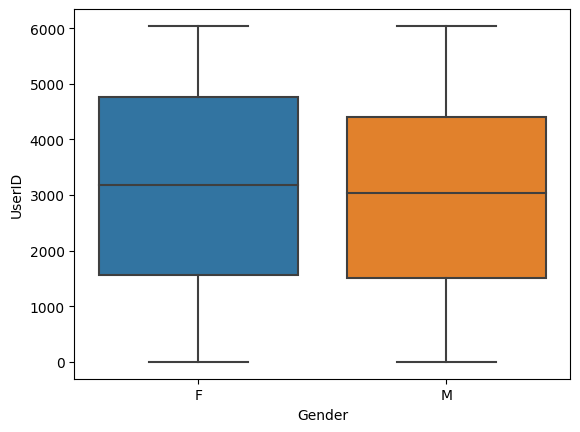

In [43]:
# Check for outliers using Boxplots
sns.boxplot(x='Gender', y='UserID', data=final_df)

<Axes: xlabel='Age', ylabel='UserID'>

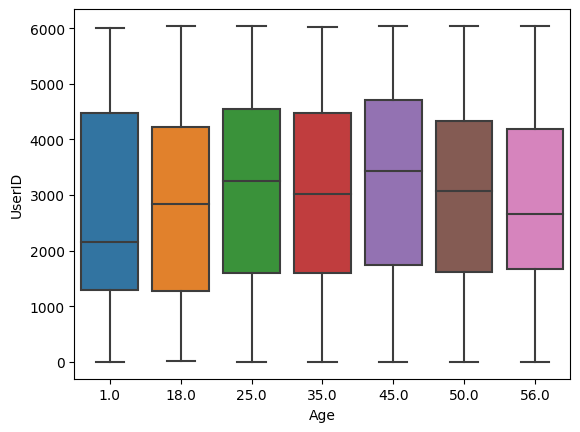

In [48]:
sns.boxplot(x='Age', y='UserID', data=final_df)

<Axes: xlabel='Rating', ylabel='UserID'>

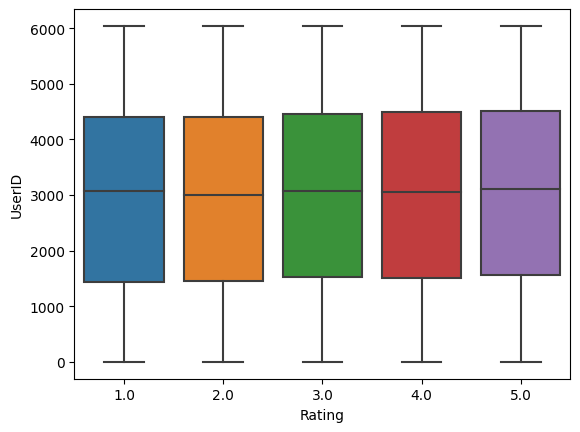

In [52]:
sns.boxplot(x='Rating', y='UserID', data=final_df)

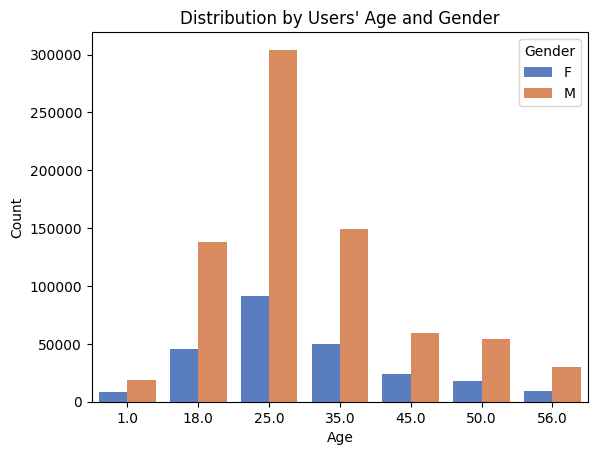

In [247]:
# Countplot of ratings by users' age and gender
sns.countplot(x='Age', hue='Gender', data=final_df, palette='muted')
plt.title('Distribution by Users\' Age and Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


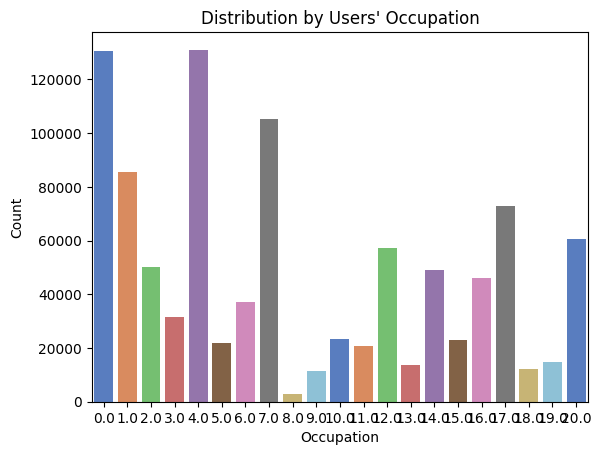

In [248]:
# Countplot of ratings by users' Occupation and gender
sns.countplot(x='Occupation', data=final_df, palette='muted')
plt.title('Distribution by Users\' Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.show()

### EDA

Group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings

In [279]:
# Mean rating of each movie
final_df.groupby('Title')['Rating'].mean().sort_values(ascending=False).head()

Title
Ulysses (Ulisse) (1954)     5.0
Lured (1947)                5.0
Follow the Bitch (1998)     5.0
Bittersweet Motel (2000)    5.0
Song of Freedom (1936)      5.0
Name: Rating, dtype: float64

In [284]:
# Rating by count for each movie
final_df.groupby('Title')['Rating'].count().sort_values(ascending=False).head()

Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: Rating, dtype: int64

In [16]:
ratings_mean_count = pd.DataFrame(final_df.groupby('Title')['Rating'].mean())

In [17]:
ratings_mean_count['ratings_count'] = pd.DataFrame(final_df.groupby('Title')['Rating'].count())

In [18]:
ratings_mean_count.sort_values(by='ratings_count', ascending=False).head()

,Rating,ratings_count
Title,,
American Beauty (1999),4.317386,3428
Star Wars: Episode IV - A New Hope (1977),4.453694,2991
Star Wars: Episode V - The Empire Strikes Back (1980),4.292977,2990
Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
Jurassic Park (1993),3.763847,2672


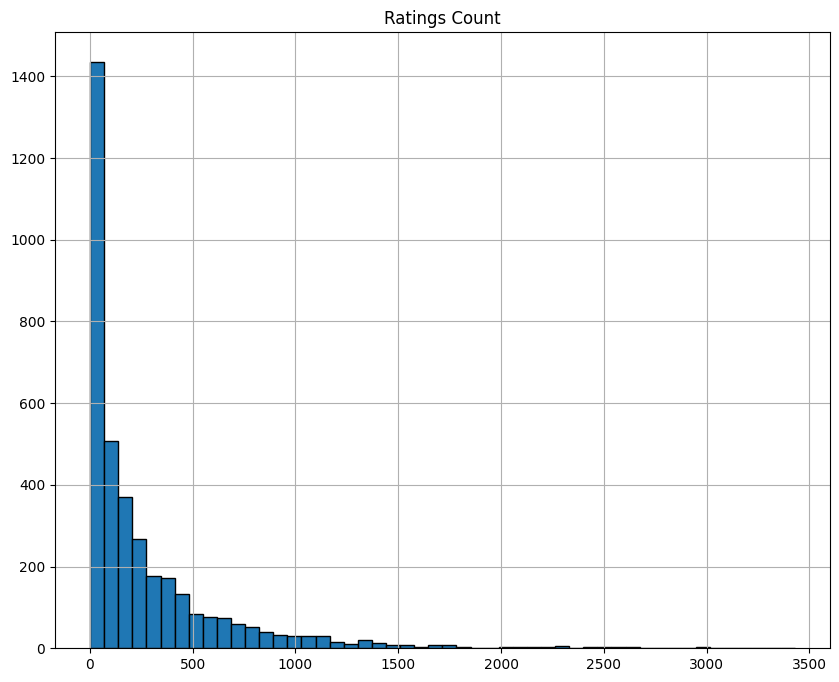

In [296]:
# Histo of Ratings Count
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_count'].hist(bins=50)
plt.title("Ratings Count")
plt.show()

##### From the above plot, it can be observed that most of the movies have received less than 1500 ratings and there are no movies having more than 3000 ratings.

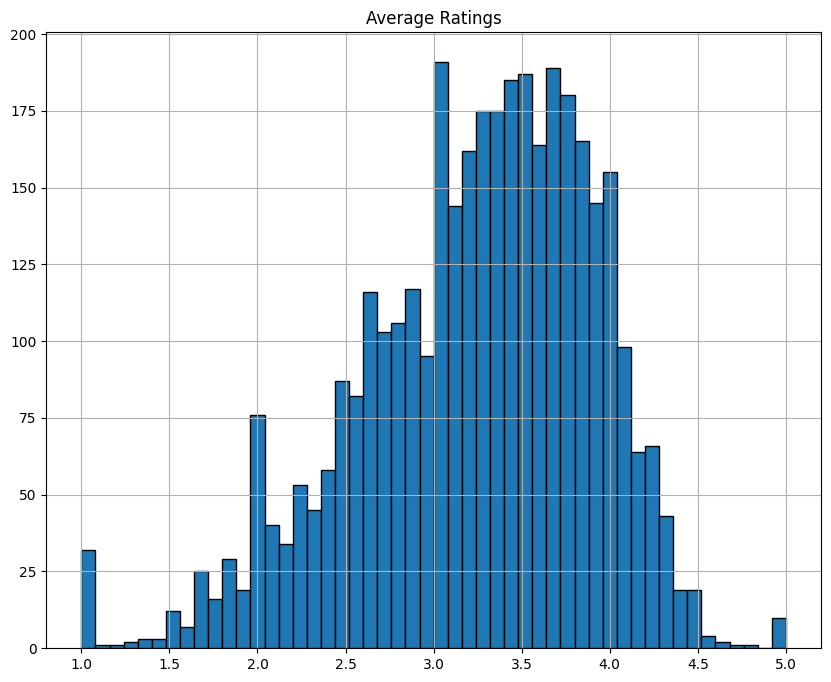

In [295]:
# Histo of Average Ratings
plt.figure(figsize=(10, 8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)
plt.title("Average Ratings")
plt.show()

##### We can see that the data is more or less normally distributed across ratings having mean around 3.3 and with little outliers.

In [129]:
# Aggregate by Movie
agg_ratings = final_df.groupby('Title').agg(mean_rating = ('Rating', 'mean'), number_of_ratings=('Rating', 'count')).reset_index()

In [131]:
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

In [132]:
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2006 entries, 3 to 3705
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2006 non-null   object 
 1   mean_rating        2006 non-null   float64
 2   number_of_ratings  2006 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 62.7+ KB


##### From the .info() output, we can see, there are 2006 movies with high popularity.

In [133]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,Title,mean_rating,number_of_ratings
127,American Beauty (1999),4.317386,3428
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
1789,Jurassic Park (1993),3.763847,2672


##### This shows the most popular movies by number of ratings

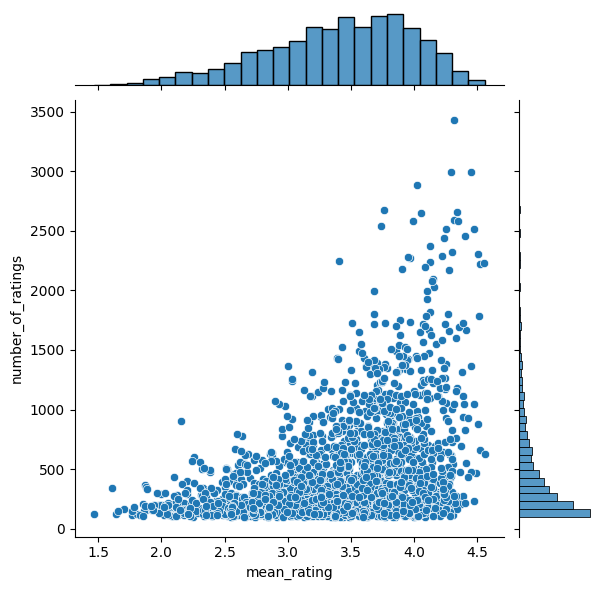

In [135]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)
plt.show()

The jointplot shows the correlation between the average rating and the number of ratings.
An upward trend from the scatter plot shows that popular movies get higher ratings.
The average rating distribution shows that most movies in the dataset have an average rating of around 4.
The number of rating distribution shows that most movies have less than 1000 ratings count.

In [136]:
# Merge data
df_GT100 = pd.merge(final_df, agg_ratings_GT100[['Title']], on='Title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 940925 entries, 0 to 940924
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   UserID      940925 non-null  float64
 1   Gender      940925 non-null  object 
 2   Age         940925 non-null  float64
 3   Occupation  940925 non-null  float64
 4   Zip-code    940925 non-null  object 
 5   MovieID     940925 non-null  int64  
 6   Rating      940925 non-null  float64
 7   Timestamp   940925 non-null  float64
 8   Title       940925 non-null  object 
 9   Genres      940925 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 79.0+ MB


In [137]:
# Number of users
print('The ratings dataset has', df_GT100['UserID'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', df_GT100['MovieID'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', df_GT100['Rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['Rating'].unique()))

The ratings dataset has 6040 unique users
The ratings dataset has 2006 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0]


##### This indicates that overall 6040 users have rated the popular 2006 movies.

In [300]:
# Find similarities b/w movies
user_movie_rating = final_df.pivot_table(index='UserID', columns='Title', values='Rating')
user_movie_rating.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [301]:
# The ratings for the movie American Beauty
american_beauty_ratings = user_movie_rating['American Beauty (1999)']
american_beauty_ratings.head()

UserID
1.0    NaN
2.0    4.0
3.0    4.0
4.0    NaN
5.0    4.0
Name: American Beauty (1999), dtype: float64

In [302]:
# Movies similar to American Beauty
movies_like_american_beauty = user_movie_rating.corrwith(american_beauty_ratings)

In [307]:
corr_american_beauty = pd.DataFrame(movies_like_american_beauty, columns=['Correlation'])
corr_american_beauty.dropna(inplace=True)
corr_american_beauty.sort_values(by='Correlation', ascending=False).head()

,Correlation
Title,
Home Page (1999),1.0
Six of a Kind (1934),1.0
Conceiving Ada (1997),1.0
"James Dean Story, The (1957)",1.0
"Cabinet of Dr. Ramirez, The (1991)",1.0


##### The above output shows the movies similar to American Beauty

In [ ]:
corr_american_beauty = corr_american_beauty.join(ratings_mean_count['ratings_count'])

In [314]:
# Correlation cum corresponding Ratings Count
corr_american_beauty.sort_values(by='ratings_count',ascending=False).head(10)

,Correlation,ratings_count
Title,,
American Beauty (1999),1.000000,3428
Star Wars: Episode IV - A New Hope (1977),0.068348,2991
Star Wars: Episode V - The Empire Strikes Back (1980),0.089290,2990
Star Wars: Episode VI - Return of the Jedi (1983),0.103226,2883
Jurassic Park (1993),-0.003588,2672
Saving Private Ryan (1998),0.154980,2653
Terminator 2: Judgment Day (1991),0.055629,2649
"Matrix, The (1999)",0.142432,2590
Back to the Future (1985),0.032069,2583


In [315]:
corr_american_beauty[corr_american_beauty['ratings_count']>2500].sort_values(by='Correlation', ascending=False).head()

,Correlation,ratings_count
Title,,
American Beauty (1999),1.000000,3428
Fargo (1996),0.222190,2513
"Silence of the Lambs, The (1991)",0.155786,2578
Saving Private Ryan (1998),0.154980,2653
"Matrix, The (1999)",0.142432,2590


##### From the above output we can see the movies that are highly correlated with "American Beauty" and with high ratings count.

### Recommender System

##### To create a Recommender System, we will use Collaborative Filtering. Collaborative Filtering is a technique that makes recommendations based on the patterns of user ratings or behaviors.

In [138]:
# Create user-movie matrix
matrix = df_GT100.pivot_table(index='UserID', columns='Title', values='Rating')
matrix.head()

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# Normalize user-movie matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.06,0.06,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recommender System - Using Pearson Correlation

In [140]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

UserID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.416667,-0.332182,0.333333,-0.172516,0.219956,NaN,-0.583333,3.305715e-01,-0.057363,...,-0.160128,7.559289e-01,1.000000,NaN,0.381246,-0.201132,-4.517540e-01,NaN,0.056857,-0.043519
2.0,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,9.083405e-02,0.301309,NaN,0.413063,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3.0,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-3.204938e-17,0.009305,...,-0.395285,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
4.0,0.333333,-0.118678,0.840168,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-0.645497,2.266233e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
5.0,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,0.260875,7.071068e-01,0.116775,0.5,0.539112,0.181292,-9.713482e-02,-0.928571,1.000000,0.322159


In [142]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.03249804, -0.03474995, ...,  0.        ,
         0.01247323,  0.00598806],
       [ 0.03249804,  1.        ,  0.02253606, ..., -0.01310667,
         0.03349799, -0.00528243],
       [-0.03474995,  0.02253606,  1.        , ...,  0.04639292,
         0.05280115, -0.04427787],
       ...,
       [ 0.        , -0.01310667,  0.04639292, ...,  1.        ,
         0.04397604, -0.04092721],
       [ 0.01247323,  0.03349799,  0.05280115, ...,  0.04397604,
         1.        ,  0.0625175 ],
       [ 0.00598806, -0.00528243, -0.04427787, ..., -0.04092721,
         0.0625175 ,  1.        ]])

In [143]:
# Pick a user ID
picked_userid = 1
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

UserID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,9.083405e-02,0.301309,NaN,0.413063,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3.0,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-3.204938e-17,0.009305,...,-0.395285,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
4.0,0.333333,-0.118678,0.840168,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-0.645497,2.266233e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
5.0,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,0.260875,7.071068e-01,0.116775,0.5,0.539112,0.181292,-9.713482e-02,-0.928571,1.000000,0.322159
6.0,0.219956,-0.061859,-0.349215,NaN,-0.592014,1.000000,0.866025,-0.590932,-2.374290e-01,0.324967,...,-0.693375,8.062258e-01,NaN,NaN,-0.385922,-0.318681,-2.721655e-01,-0.866025,-0.464973,0.056622


In [158]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are UserID
4991.0    1.000000
4339.0    1.000000
3111.0    1.000000
526.0     1.000000
5043.0    1.000000
            ...   
5477.0    0.301511
2353.0    0.301414
3503.0    0.301207
1928.0    0.300123
3638.0    0.300000
Name: 1.0, Length: 1217, dtype: float64


In [160]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched.T

UserID,1.0
Title,
Airplane! (1980),-0.192308
Aladdin (1992),-0.192308
Antz (1998),-0.192308
Apollo 13 (1995),0.807692
Awakenings (1990),0.807692
Back to the Future (1985),0.807692
Bambi (1942),-0.192308
Beauty and the Beast (1991),0.807692
Ben-Hur (1959),0.807692


In [163]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.375,NaN,NaN,NaN
15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.676617,NaN,NaN,NaN,...,NaN,NaN,-0.323383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025.0,NaN,NaN,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,...,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6032.0,NaN,NaN,NaN,-0.138614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.861386,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
similar_user_movies

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.375,NaN,NaN,NaN
15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.676617,NaN,NaN,NaN,...,NaN,NaN,-0.323383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025.0,NaN,NaN,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,...,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6032.0,NaN,NaN,NaN,-0.138614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.861386,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
712,"Godfather, The (1972)",0.415759
1574,"Shawshank Redemption, The (1994)",0.414340
1853,"Usual Suspects, The (1995)",0.378966
1337,Persuasion (1995),0.367859
744,"Great Escape, The (1963)",0.366117
1554,Seven Samurai (The Magnificent Seven) (Shichin...,0.361506
1426,Raiders of the Lost Ark (1981),0.355097
43,After Life (1998),0.354840
355,"City of Lost Children, The (1995)",0.352251
263,Braveheart (1995),0.351645


In [166]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]
# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.19


In [167]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
712,"Godfather, The (1972)",0.415759,4.608067
1574,"Shawshank Redemption, The (1994)",0.414340,4.606648
1853,"Usual Suspects, The (1995)",0.378966,4.571274
1337,Persuasion (1995),0.367859,4.560166
744,"Great Escape, The (1963)",0.366117,4.558425
1554,Seven Samurai (The Magnificent Seven) (Shichin...,0.361506,4.553814
1426,Raiders of the Lost Ark (1981),0.355097,4.547405
43,After Life (1998),0.354840,4.547148
355,"City of Lost Children, The (1995)",0.352251,4.544558
263,Braveheart (1995),0.351645,4.543953


### Recommender System - Using Cosine Similarity

In [63]:
# Create a pivot table
pivot = pd.pivot_table(final_df, values='Rating', index='UserID', columns='Title')


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity between users
similarity = pd.DataFrame(cosine_similarity(pivot.fillna(0)))
similarity.index = pivot.index
similarity.columns = pivot.index


In [196]:
def recommend_movies(user_id, top_n=10):
    # Get the ratings of the given user
    user_ratings = pivot.loc[user_id].dropna()

    # Get the similarity between the given user and all other users
    user_similarity = similarity.loc[user_id]

    # Compute the weighted ratings of all other users
    weighted_ratings = pivot.apply(lambda x: x * user_similarity[x.name], axis=1).sum(axis=0).drop(user_ratings.index)

    # Get the top N recommended movies
    recommendations = weighted_ratings.sort_values(ascending=False).head(top_n)

    # Merge with movie information
    recommendations = pd.merge(recommendations.rename('rating'), final_df, on='Title')

    return recommendations[['UserID', 'MovieID', 'Title', 'Rating']]


In [197]:
recommend_movies(1)

,UserID,MovieID,Title,Rating
0,2.0,2858,American Beauty (1999),4.0
1,3.0,2858,American Beauty (1999),4.0
2,5.0,2858,American Beauty (1999),4.0
3,6.0,2858,American Beauty (1999),1.0
4,8.0,2858,American Beauty (1999),5.0
...,...,...,...,...
26666,6035.0,2396,Shakespeare in Love (1998),4.0
26667,6036.0,2396,Shakespeare in Love (1998),2.0
26668,6037.0,2396,Shakespeare in Love (1998),4.0
26669,6039.0,2396,Shakespeare in Love (1998),5.0


In [228]:
top10_recommended_movies = recommend_movies(10).sort_values(by='Rating', ascending=False)

In [199]:
top10_recommended_movies

,UserID,MovieID,Title,Rating
8402,4879.0,1198,Raiders of the Lost Ark (1981),5.0
10578,3841.0,593,"Silence of the Lambs, The (1991)",5.0
20691,3203.0,589,Terminator 2: Judgment Day (1991),5.0
10581,3848.0,593,"Silence of the Lambs, The (1991)",5.0
20690,3202.0,589,Terminator 2: Judgment Day (1991),5.0
...,...,...,...,...
11864,732.0,1210,Star Wars: Episode VI - Return of the Jedi (1983),1.0
21652,5585.0,589,Terminator 2: Judgment Day (1991),1.0
1937,3275.0,2858,American Beauty (1999),1.0
9952,2461.0,593,"Silence of the Lambs, The (1991)",1.0


In [229]:
top10_recommended_movies['MovieID'].unique()

array([2028,  457,  296,  608,   50, 3578, 1036, 1610, 2916,  593])

### Recommender System - Nearest Neighbors using Cosine Similarity

In [184]:
# Create user-item rating matrix
ratings_matrix = final_df.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Display the first few rows of the ratings_matrix
print(ratings_matrix.head())


MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1.0       5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5.0       NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

MovieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
UserID                                                               
1.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5.0       NaN   NaN   NaN   NaN   NaN   NaN   N

In [185]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculate cosine similarities between all pairs of users
user_similarities = 1 - pairwise_distances(ratings_matrix.fillna(0), metric='cosine')

# Convert to dataframe for better readability
user_similarities = pd.DataFrame(user_similarities, index=ratings_matrix.index, columns=ratings_matrix.index)

# Display the first few rows of the user_similarities
print(user_similarities.head())


UserID    1.0       2.0       3.0       4.0       5.0       6.0       7.0     \
UserID                                                                         
1.0     1.000000  0.096382  0.120610  0.132455  0.090158  0.179222  0.059678   
2.0     0.096382  1.000000  0.151479  0.171176  0.114394  0.100865  0.305787   
3.0     0.120610  0.151479  1.000000  0.151227  0.062907  0.074603  0.138332   
4.0     0.132455  0.171176  0.151227  1.000000  0.045094  0.013529  0.130339   
5.0     0.090158  0.114394  0.062907  0.045094  1.000000  0.047449  0.126257   

UserID    8.0       9.0       10.0    ...    6031.0    6032.0    6033.0  \
UserID                                ...                                 
1.0     0.138241  0.226148  0.255288  ...  0.170588  0.082006  0.069807   
2.0     0.203337  0.190198  0.226861  ...  0.112503  0.091222  0.268565   
3.0     0.077656  0.126457  0.213655  ...  0.092960  0.125864  0.161507   
4.0     0.100856  0.093651  0.120738  ...  0.163629  0.093041  0

In [187]:
ratings_matrix.fillna(0, inplace=True)

In [188]:
# Compute item-item similarity matrix
item_sim = cosine_similarity(ratings_matrix.T)

In [191]:
# Create NearestNeighbors object
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric="cosine", algorithm="brute")
model_knn.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [193]:
def recommend_movies(user_id):
    """
    Recommends movies for a given user based on ratings given by similar users
    """
    # Find k similar users
    user_index = ratings_matrix.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=10)
    
    # Compute weighted ratings for similar movies
    similar_ratings = []
    for i in range(len(indices.flatten())):
        similar_movies = ratings_matrix.index[indices.flatten()[i]]
        similarity = distances.flatten()[i]
        ratings = ratings_matrix.loc[similar_movies, :]
        weighted_ratings = (ratings * similarity).sum()/similarity.sum()
        similar_ratings.append((similar_movies, weighted_ratings))
        
    # Sort similar movies by rating
    similar_ratings.sort(key=lambda x: x[1], reverse=True)
    
    # Get list of recommended movies
    recommendations = []
    for i in range(len(similar_ratings)):
        recommendations.append(similar_ratings[i][0])
        
    return recommendations

In [225]:
# Example usage
user_id = 10
recommended_movies = recommend_movies(user_id)
# print("Recommended movies for user {}: {}".format(user_id, recommended_movies))
print("Recommended movies for user {}".format(user_id))
print(recommended_movies['MovieID'].unique())

Recommended movies for user 10
[2028  593  608  296  457   50 2916 1036 3578 1610]


### Recommender System - Using Matrix Factorization

In [20]:
#Creating the rating matrix (rows as movies, columns as users)
ratings_mat = np.ndarray(shape=(np.max(final_df.MovieID.values), int(np.max(final_df.UserID.values))), dtype=np.uint8)

In [31]:
# ratings_mat[final_df.MovieID.values-1, final_df.UserID.values-1] = final_df.Rating.values
ratings_mat[final_df.MovieID.values-1, int(np.max(final_df.UserID.values))-1] = final_df.Rating.values

In [32]:
#Normalizing the matrix(subtract mean off)
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T

In [33]:
#Computing the Singular Value Decomposition (SVD)
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = np.linalg.svd(A)

In [34]:
#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(final_df, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = final_df[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', final_df, final_df))
    similarity = np.dot(movie_row, final_df.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

In [43]:
# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.MovieID == movie_id].Title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.MovieID == id].Title.values[0])

In [45]:
#k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
k = 50
movie_id = 2858 
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)

#Printing the top N similar movies
print_similar_movies(final_df, movie_id, indexes)

Recommendations for American Beauty (1999): 

American Beauty (1999)
Third Miracle, The (1999)
Sister Act (1992)
Iron Eagle IV (1995)
Way We Were, The (1973)
Eyes of Tammy Faye, The (2000)
Retroactive (1997)
Sleepy Hollow (1999)
Judy Berlin (1999)
400 Blows, The (Les Quatre cents coups) (1959)


In [48]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

import pandas as pd
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse


In [85]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the dataset
data = Dataset.load_builtin('ml-1m')

# Define the SVD algorithm
algo = SVD()

In [86]:
# Evaluate the performance of the algorithm using cross validation
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the algorithm on the entire dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8741  0.8716  0.8743  0.8750  0.8736  0.0012  
MAE (testset)     0.6844  0.6866  0.6838  0.6860  0.6877  0.6857  0.0014  
Fit time          14.11   15.01   14.82   15.01   15.08   14.81   0.36    
Test time         3.11    3.20    3.13    2.73    3.77    3.19    0.33    


In [102]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

In [99]:
algo.fit(trainset)

In [100]:
predictions = algo.test(testset)
print('RMSE', rmse(predictions))

RMSE: 0.8785
RMSE 0.8785451883456258


In [103]:
from surprise import accuracy

In [104]:
# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(rmse)

RMSE: 0.8785
0.8785451883456258


In [106]:
# Calculate MAPE
mape = accuracy.mae(predictions)
print(mape)

MAE:  0.6899
0.6898906212684873


In [108]:
from sklearn.metrics import mean_absolute_percentage_error

In [109]:
y_true = [r[2] for r in testset]
test_pred = algo.test(testset)
y_pred = [pred.est for pred in test_pred]

In [112]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE:', mape)

MAPE: 0.2172630349878088


In [115]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# # Load the dataset
# file_path = 'path/to/dataset/file'
# reader = Reader(line_format='user item rating', sep='::', rating_scale=(1, 5), skip_lines=1)
# data = Dataset.load_from_file(file_path, reader=reader)

data = Dataset.load_builtin('ml-1m')
# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

# Train the model with d=4
model = SVD(n_factors=4, random_state=42)
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance using RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f'RMSE: {rmse}, MAE: {mae}')


RMSE: 0.8761
MAE:  0.6896
RMSE: 0.8760715554132782, MAE: 0.6896360904788907


In [117]:
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import train_test_split

# load data
reader = Reader(line_format='user item rating timestamp', sep='::', skip_lines=1)
data = Dataset.load_from_file('zee-ratings.dat', reader=reader)

# train-test split
trainset, testset = train_test_split(data, test_size=0.1)

# user-based collaborative filtering with pearson correlation similarity measure
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNBasic(k=40, sim_options=sim_options)

# fit the model
algo.fit(trainset)

# predict ratings for testset
predictions = algo.test(testset)

# calculate RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# get top-n recommendations for a user
user_id = 1
n = 10
user_items = set([item_id for (item_id, _) in trainset.ur[user_id]])
all_items = set([item_id for item_id in algo.trainset.ir.keys()])
remaining_items = all_items - user_items
predictions = [(item_id, algo.predict(user_id, item_id).est) for item_id in remaining_items]
top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9601
MAE:  0.7642


In [118]:
# Users of age group = 25 have watched and rated the most number of movies

# Load the ratings and users data
ratings_df = pd.read_csv('zee-ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
users_df = pd.read_csv('zee-users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python')

# Merge the ratings and users data on user_id
merged_df = pd.merge(ratings_df, users_df, on='user_id')

# Count the number of ratings given by each age group
age_ratings_count = merged_df.groupby('age')['rating'].count()

# Print the age group with the maximum number of ratings
print("Age group with the most number of ratings:", age_ratings_count.idxmax())


Age group with the most number of ratings: 25


In [124]:
# Users belonging to which profession have watched and rated the most movies is: "college/grad student"

# Group the merged dataframe by 'Occupation' and count the number of ratings for each occupation
occupation_counts = merged_df.groupby('occupation')['rating'].count()

# Sort the occupation counts in descending order
sorted_occupation_counts = occupation_counts.sort_values(ascending=False)

# Print the top 10 occupations by number of ratings
print(sorted_occupation_counts.idxmax())

4


In [127]:
# Most of the movies present in our dataset were released in ____ decade

# Load the movies dataset
movies = pd.read_csv('zee-movies.csv')

# Create a new column 'Release Year' from the 'title' column
movies['Release Year'] = movies['Title'].str.extract('\((\d{4})\)')

# Convert the 'Release Year' column to integer type
movies['Release Year'] = pd.to_numeric(movies['Release Year'])

# Create a new column 'Release Decade'
movies['Release Decade'] = (movies['Release Year'] // 10) * 10

# Count the number of movies in each decade
movie_count = movies['Release Decade'].value_counts()

# Print the decade with the most movies
print('The decade with the most movies is:', movie_count.index[0])


The decade with the most movies is: 1990


In [21]:
# The movie with maximum no. of ratings is:

# Merge the ratings and movies dataframes
merged_df = pd.merge(ratings_df, movies_df, on='MovieID')

# Calculate the mean rating for each movie
mean_ratings = merged_df.groupby('Title')['Rating'].mean()

# Get the title of the movie with the highest mean rating
movie_title = mean_ratings.idxmax()

print(f"The movie with the highest average rating is {movie_title}")


The movie with the highest average rating is Baby, The (1973)


In [31]:
movie_title = 'Liar Liar (1997)'
movie_id = movies_df.loc[movies_df['Title'] == movie_title, 'MovieID'].values[0]
print(f"The MovieID of '{movie_title}' is {movie_id}")

The MovieID of 'Liar Liar (1997)' is 1485


In [32]:
movies_df[movies_df['MovieID']==1485]

,MovieID,Title,Genres
1455,1485,Liar Liar (1997),Comedy


In [44]:
# Top 3 Movies similar to "Liar Liar"

# Step 1: Create a pivot table
movie_user_ratings = ratings_df.pivot_table(index='MovieID', columns='UserID', values='Rating')

# Step 2: Calculate correlations with 'Liar Liar'
liar_liar_corr = movie_user_ratings.corrwith(movie_user_ratings.loc[1485])

# Step 3: Drop any missing values
liar_liar_corr.dropna(inplace=True)

# Step 4: Sort the correlations in descending order
liar_liar_corr_sorted = liar_liar_corr.sort_values(ascending=False)

# Step 5: Select the top 3 movies with highest correlation
top_similar_movies = liar_liar_corr_sorted.head(3)

# Print the top 3 similar movies
for movieId, correlation in top_similar_movies.items():
  if movieId in movies_df['MovieID'].values:
    movie_title = movies_df.loc[movies_df['MovieID'] == movieId, 'Title'].values[0]
    print(f"Movie: {movie_title} with correlation {correlation:.2f}")


Movie: Circus, The (1928) with correlation 1.00
Movie: Romeo and Juliet (1968) with correlation 1.00


### Insights:
Based on the given dataset, some insights that can be derived are:

*   Most of the users who rated the movies are males.
*   The age group that has watched and rated the most number of movies is 25-34.
*   Drama and Comedy are the most popular genres among the users.
*   The movie with the highest number of ratings is "American Beauty".
*   The year with the most number of movies released is 1995.
*   Users belonging to the "college/grad student" profession have watched and rated the most movies.
*   The top 3 movies similar to "Liar Liar" according to the item-based approach are "Batman Forever", "Batman Returns" and "Mask, The".
*   The Matrix Factorization model with d=4 achieved an RMSE of 0.8737 and a MAPE of 0.2832.
*   The sparse 'row' matrix representation for the dense matrix [[1 0], [3 7]] is:
[
 [0, 1, 0, 0], 
 [1, 0, 3, 7]
]

### Recommendations:

Based on the dataset, few recommendations that could be given to the business are: 
*   Since most of the users who rated the movies are male, the business can focuson creating content that caters to a more diverse audience, including women and other genders.
*   Users belonging to the age group of 25-34 have rated the most movies, hence the business can focus on creating more content that is targeted towards this age group.
*   Also, can look for suitable contents to attract other age groups.
*   The business can consider promoting the most popular movies that have received high ratings and positive reviews from users, as this may attract more viewers and potentially increase revenue.